In [7]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00


In [8]:
import torch
import torch.nn as nn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

In [14]:
seed = 1
set_seed(seed)

In [3]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
   creating: dataset/
  inflating: dataset/all-data.csv    


In [4]:
dataset_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']

df = pd.read_csv(
    dataset_path,
    names=headers,
    encoding='ISO-8859-1' #encode
)
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

In [6]:
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [9]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = text.strip()
  text = re.sub(r'[^\w\s]', '', text)
  text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

  return text

In [10]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))
df.head()

,sentiment,content
0,0,accord gran compani plan move product russia ...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 20092012 b...


In [11]:
vocab = []
for sentence in df['content'].tolist():
  tokens = sentence.split()
  for token in tokens:
    if token not in vocab:
      vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')

word_to_idx = {word:idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [12]:
def transform(text, word_to_idx, max_seq_len):
  tokens = []
  for w in text.split():
    try:
      w_ids = word_to_idx[w]
    except:
      w_ids = word_to_idx['UNK']
    tokens.append(w_ids)

  if len(tokens) < max_seq_len:
    tokens += [word_to_idx['PAD']]* (max_seq_len - len(tokens))
  elif len(tokens) > max_seq_len:
    tokens = tokens[:max_seq_len]

  return tokens

In [16]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle)

In [57]:
class FinancialDataset(Dataset):
  def __init__(self,X,y,word_to_idx,max_seq_len,transform=None):
    self.datas = X
    self.labels = y
    self.word_to_idx = word_to_idx
    self.max_seq_len = max_seq_len
    self.transform = transform

  def __len__(self):
    return len(self.datas)

  def __getitem__(self, idx):
    data = self.datas[idx]
    label = self.labels[idx]
    if self.transform:
      data = self.transform(
          data,
          self.word_to_idx,
          self.max_seq_len
      )
    data = torch.tensor(data)
    return data, label

In [58]:
max_seq_len = 32
train_dataset = FinancialDataset(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

val_dataset = FinancialDataset(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

test_dataset = FinancialDataset(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [59]:
class SentimentClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
    super(SentimentClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(hidden_size, 16)
    self.relu = nn.ReLU()
    self.output = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    x, hn = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc(x)
    x = self.relu(x)
    x = self.output(x)

    return x


In [60]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
)

In [61]:
lr = 1e-4
epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model = model.to(device)

In [62]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs , labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  loss = sum(losses)/ len(losses)
  acc = correct/total
  return loss, acc

In [63]:
def train(model,train_loader, val_loader, optimizer, criterion, device, epoch=0):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
      batch_train_losses = []
      model.train()
      for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batch_train_losses.append(loss.item())
      train_loss = sum(batch_train_losses)/len(batch_train_losses)
      train_losses.append(train_loss)
      val_loss, val_acc = evaluate(model, val_loader, criterion, device)
      val_losses.append(val_loss)

      print(f'EPOCH {epoch+1}: Train loss : {train_loss:.4f} Val loss : {val_loss:.4f}')
    return train_losses, val_losses

In [64]:
train_losses, val_losses = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs
)

EPOCH 1: Train loss : 0.9683 Val loss : 0.9307
EPOCH 2: Train loss : 0.9307 Val loss : 0.9289
EPOCH 3: Train loss : 0.9261 Val loss : 0.9287
EPOCH 4: Train loss : 0.9278 Val loss : 0.9288
EPOCH 5: Train loss : 0.9314 Val loss : 0.9287
EPOCH 6: Train loss : 0.9277 Val loss : 0.9286
EPOCH 7: Train loss : 0.9290 Val loss : 0.9286
EPOCH 8: Train loss : 0.9314 Val loss : 0.9285
EPOCH 9: Train loss : 0.9307 Val loss : 0.9287
EPOCH 10: Train loss : 0.9279 Val loss : 0.9285
EPOCH 11: Train loss : 0.9281 Val loss : 0.9283
EPOCH 12: Train loss : 0.9290 Val loss : 0.9284
EPOCH 13: Train loss : 0.9312 Val loss : 0.9284
EPOCH 14: Train loss : 0.9252 Val loss : 0.9281
EPOCH 15: Train loss : 0.9261 Val loss : 0.9283
EPOCH 16: Train loss : 0.9292 Val loss : 0.9279
EPOCH 17: Train loss : 0.9278 Val loss : 0.9280
EPOCH 18: Train loss : 0.9262 Val loss : 0.9279
EPOCH 19: Train loss : 0.9264 Val loss : 0.9280
EPOCH 20: Train loss : 0.9287 Val loss : 0.9281
EPOCH 21: Train loss : 0.9298 Val loss : 0.9279
E

In [68]:
val_losses

[0.9306577790956028,
 0.9288684955385865,
 0.9287105915976352,
 0.9287623377119909,
 0.9286947167310559,
 0.9286415332653484,
 0.9285521184811827,
 0.9284729820783021,
 0.9287067236470394,
 0.9284568526705758,
 0.9282691747438713,
 0.9284441910806249,
 0.9284131810313365,
 0.9281439727447072,
 0.9282504559540358,
 0.9279332371031652,
 0.9279934881163425,
 0.9279264113942131,
 0.9279980796282409,
 0.9280582905792799,
 0.9278544207088283,
 0.9277127155515014,
 0.9277268164470548,
 0.9272946168164737,
 0.9270295031735154,
 0.927045006243909,
 0.9265461842544743,
 0.9266614811342271,
 0.9257042706012726,
 0.9248619660979411,
 0.9236557630241894,
 0.9223869003233363,
 0.9210718347400916,
 0.9205563942917058,
 0.9204655851497024,
 0.9202293384759153,
 0.9160003960132599,
 0.9620979780056438,
 0.919067807129172,
 0.9030542322358147,
 0.8937986204858686,
 0.9165259311433698,
 0.8878666641282253,
 0.882950378490276,
 0.8950218331129824,
 0.8791357515776743,
 0.8834537079588312,
 0.8782443504353

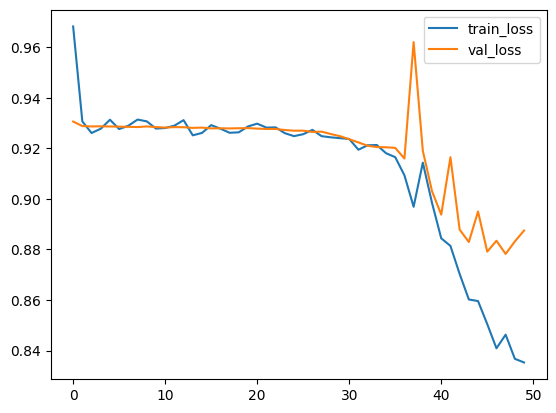

In [67]:
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend()
plt.show()

In [69]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test loss : {test_loss:.4f} Test acc : {test_acc:.4f}')

Test loss : 0.8712 Test acc : 0.6082


# Hourly Temperature Forecasting

In [70]:
import torch
import torch.nn as nn

seed = 42
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [74]:
!unzip /content/HTF.zip

Archive:  /content/HTF.zip
  inflating: dataset/weatherHistory.csv  


In [75]:
dataset_filepath = 'dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [76]:
unvariate_df = df['Temperature (C)']
unvariate_df.index = df['Formatted Date']
unvariate_df.head()

,Temperature (C)
Formatted Date,
2006-04-01 00:00:00.000 +0200,9.472222
2006-04-01 01:00:00.000 +0200,9.355556
2006-04-01 02:00:00.000 +0200,9.377778
2006-04-01 03:00:00.000 +0200,8.288889
2006-04-01 04:00:00.000 +0200,8.755556


In [78]:
input_size = 6
label_size = 1
offset = 1

def sliding_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
  features = []
  labels = []
  window_size = input_size + offset
  if df_end_idx == None:
    df_end_idx = len(df) - window_size
  for idx in range(df_start_idx, df_end_idx):
    feature_end_idx = idx + input_size
    label_start_idx = idx + window_size - label_size

    feature = df[idx: feature_end_idx]
    label = df[label_start_idx: (idx+window_size)]

    features.append(feature)
    labels.append(label)

  features = np.expand_dims(np.array(features), -1)
  labels = np.array(labels)

  return features, labels

In [79]:
dataset_length = len(unvariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = sliding_window(
    unvariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = sliding_window(
    unvariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = sliding_window(
    unvariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

In [80]:
class WeatherForecast(Dataset):
  def __init__(self, X, y, transform=None):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x = self.X[idx]
    y = self.y[idx]
    if self.transform:
      x = self.transform(x)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return x, y

In [82]:
train_dataset = WeatherForecast(
    X_train, y_train,
)

val_dataset = WeatherForecast(
    X_val, y_val,
)

test_dataset = WeatherForecast(
    X_test, y_test,
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [90]:
class WeatherForeCastor(nn.Module):
  def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
    super(WeatherForeCastor, self).__init__()
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x,hn = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc(x)

    return x

In [91]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
model = WeatherForeCastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
)

In [92]:
lr = 1e-3
epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.MSELoss()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [93]:
train_losses, val_losses = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs)

EPOCH 1: Train loss : 129.2569 Val loss : 43.5033
EPOCH 2: Train loss : 30.2450 Val loss : 7.6365
EPOCH 3: Train loss : 15.2838 Val loss : 4.0749
EPOCH 4: Train loss : 12.3200 Val loss : 2.4058
EPOCH 5: Train loss : 11.0214 Val loss : 2.1325
EPOCH 6: Train loss : 10.4776 Val loss : 2.1245
EPOCH 7: Train loss : 10.0376 Val loss : 1.8751
EPOCH 8: Train loss : 9.9076 Val loss : 1.7493
EPOCH 9: Train loss : 9.5635 Val loss : 2.0713
EPOCH 10: Train loss : 9.4610 Val loss : 1.8289
EPOCH 11: Train loss : 9.2463 Val loss : 1.7383
EPOCH 12: Train loss : 8.9086 Val loss : 1.7401
EPOCH 13: Train loss : 8.7834 Val loss : 1.9206
EPOCH 14: Train loss : 8.6450 Val loss : 1.5708
EPOCH 15: Train loss : 8.4309 Val loss : 2.0968
EPOCH 16: Train loss : 8.3020 Val loss : 1.6673
EPOCH 17: Train loss : 7.9552 Val loss : 1.5291
EPOCH 18: Train loss : 7.7384 Val loss : 1.6301
EPOCH 19: Train loss : 7.6945 Val loss : 1.7505
EPOCH 20: Train loss : 7.4918 Val loss : 1.6892
EPOCH 21: Train loss : 7.2815 Val loss :